# Spectral Clustering News Stories

The first step is to gather some data.  Our goal here will be to use goose3 to parse a Google News page, and use a small custom function to generate a list of news articles that we want to parse.

The goal of clustering these news articles is to identify topics. Google will likely give us a few potential tags we could use for each article including the overarching list of topics such as:
  * U.S.
  * World
  * Sports
  * Technology
  * Entertainment
  * etc...

In [16]:
# For Scraping Google News
import bs4
import lxml #xml parser
import ssl
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen

# For Scraping Articles
from goose3 import Goose

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

def scape_news_links(xml_news_url):
    '''
    Provide a url which will return an XML file to parse. Returns the links to news stories.
    
    Params
    ------
    xml_news_url: string
        A URL which will return 
    '''

    context = ssl._create_unverified_context()
    Client=urlopen(xml_news_url, context=context)
    xml_page=Client.read()
    Client.close()

    soup_page=soup(xml_page,"xml")

    news_list=soup_page.findAll("item")

    return [news.link.text for news in news_list]

def scrape_news_articles(topics=[]):
    if topics == []:
        topics = ['WORLD', 'SPORTS', 'TECHNOLOGY', 'BUSINESS', 'ENTERTAINMENT', 'SCIENCE', 'HEALTH']
    stem = "https://news.google.com/news/rss/headlines/section/topic/"
    g = Goose()
    articles = []
    for topic in topics:
        links = scape_news_links(stem + topic)
        for link in tqdm(links):
            try:
                article = g.extract(url=link)
                articles.append({
                    'title': article.title,
                    'tag': topic,
                    'text': article.cleaned_text
                })
            except:
                pass
    return articles

In [17]:
pull_new = False
if pull_new:
    data = scrape_news_articles()
    df = pd.DataFrame(data)
    df.to_pickle('data/raw_articles.pickle')
    df.to_csv('data/raw_articles.csv')
else:
    df = pd.read_pickle('data/raw_articles.pickle')
encoder = LabelEncoder()
df['tag'] = encoder.fit_transform(df['tag'])
df.head()

,tag,text,title
0,6,U.S. To Lift Tariffs On Steel And Aluminum Fro...,U.S. To Lift Tariffs On Steel And Aluminum Fro...
1,6,Rep. Tulsi Gabbard said she looks forward to a...,Rep. Tulsi Gabbard warns war with Iran would m...
2,6,Get YouTube without the ads.,Brexit talks between Labour and the Conservati...
3,6,LONDON/OSLO (Reuters) - Iran’s elite Revolutio...,Exclusive: Insurer says Iran's Guards likely t...
4,6,Thousands of marriage-equality advocates celeb...,Taiwan becomes first in Asia to legalize same-...


## Transform Data with TF-IDF
The next steps are to do so initial data processing.  We will first want a bag of words representation of the all of our articles, and then we'll scale that matrix by TF-IDF to complete our feature engineering in this case study.

The case study wants us to use MITIE, which looks like a MIT homebrewed solution and having never heard of it I'm not super interested in using this one.  Instead I will leverage scikit learn to perform these relatively simple tasks all in one pass.

In [18]:
stop_words = ["a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorized = vectorizer.fit_transform(df['text'])
dense = vectorized.todense()
vectorized.shape

(490, 19755)

Some quick spot checks verify that this very large and sparse array looks like it could be the TF-IDF representation of our documents. At the very least, we see a reasonable shape with the correct number of rows. 

### Time to Cluster: Spectral Clustering
With spectral clustering we first calculate the laplacian of a graph representing our data.  Clustering is then done on the relevant eiganvectors.

In [19]:
model = SpectralClustering(n_clusters=7,
                           affinity="nearest_neighbors",
                           n_neighbors = 30)

model.fit(vectorized)
base_predictions = model.labels_
base_predictions

array([5, 1, 3, 1, 1, 1, 3, 5, 1, 5, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 5, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 5, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 3, 0, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 4, 0, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1,
       4, 4, 4, 4, 1, 4, 4, 0, 4, 4, 6, 0, 4, 4, 1, 3, 4, 1, 4, 4, 1, 4,
       4, 4, 4, 3, 4, 1, 4, 4, 4, 4, 4, 4, 0, 4, 1, 4, 4, 1, 4, 4, 3, 4,
       1, 1, 5, 4, 3, 0, 4, 4, 0, 0, 1, 1, 5, 5, 1, 5, 1, 4, 5, 1, 5, 5,
       1, 5, 5, 1, 5, 1, 5, 1, 5, 1, 4, 5, 4, 1, 1, 5, 1, 5, 5, 1, 1, 5,
       5, 3, 5, 1, 5, 5, 1, 4, 5, 1, 5, 5, 5, 5, 1, 1, 1, 5, 5, 5, 1, 5,
       1, 5, 1, 4, 5, 1, 5, 5, 5, 1, 1, 5, 1, 1, 5, 5, 0, 1, 1, 1, 1, 3,
       5, 4, 0, 3, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0,

So we've successfully clustered our articles, and there is some indication that we're even doing a pretty decent job for some of the possible labels.  However, currently we can only look at the set of labels.  Might there be a way to visualize this?  I will try out both PCA and T-SNE to process the TF-IDF representation to reduce the dimensions to 2.

In [20]:
pca = PCA(n_components=2)
p_embedding = pca.fit_transform(dense)

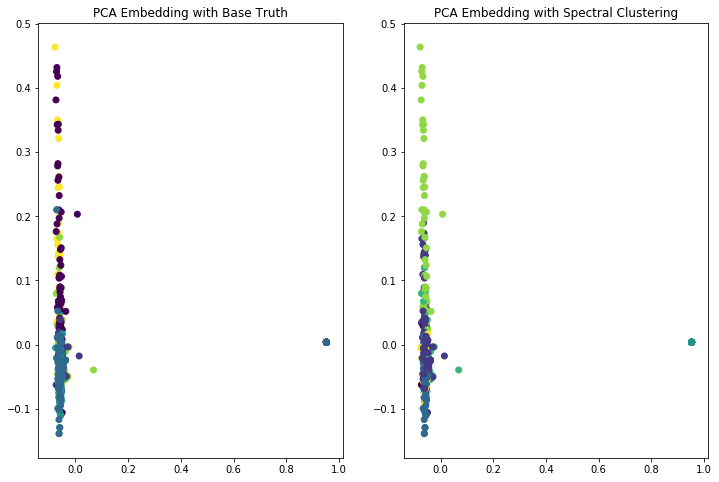

In [21]:
f, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].scatter(p_embedding[:, 0], 
              p_embedding[:, 1],
              c=df['tag'])
ax[0].set_title("PCA Embedding with Base Truth")
ax[1].scatter(p_embedding[:, 0], 
              p_embedding[:, 1],
              c=base_predictions)
ax[1].set_title("PCA Embedding with Spectral Clustering")

plt.show()

In [26]:
tsne = TSNE(n_components=2, perplexity=20.0, early_exaggeration=12.0, 
            learning_rate=300.0, n_iter=1000, n_iter_without_progress=300,
            verbose=0)
t_embedding = tsne.fit_transform(dense)

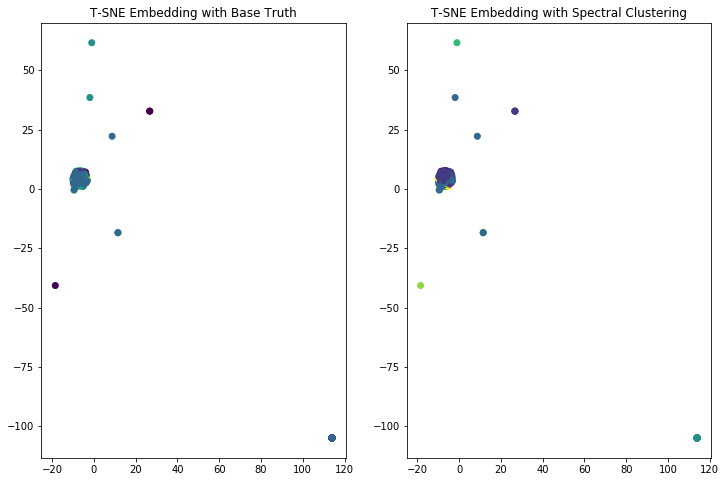

In [27]:
f, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].scatter(t_embedding[:, 0], 
              t_embedding[:, 1], 
              c=df['tag'])
ax[0].set_title("T-SNE Embedding with Base Truth")
ax[1].scatter(t_embedding[:, 0], 
              t_embedding[:, 1], 
              c=base_predictions)
ax[1].set_title("T-SNE Embedding with Spectral Clustering")

plt.show()

In [24]:
df['predictions'] = base_predictions
df.head()

,tag,text,title,predictions
0,6,U.S. To Lift Tariffs On Steel And Aluminum Fro...,U.S. To Lift Tariffs On Steel And Aluminum Fro...,5
1,6,Rep. Tulsi Gabbard said she looks forward to a...,Rep. Tulsi Gabbard warns war with Iran would m...,1
2,6,Get YouTube without the ads.,Brexit talks between Labour and the Conservati...,3
3,6,LONDON/OSLO (Reuters) - Iran’s elite Revolutio...,Exclusive: Insurer says Iran's Guards likely t...,1
4,6,Thousands of marriage-equality advocates celeb...,Taiwan becomes first in Asia to legalize same-...,1


### A Last Attempt to Quantitatively Evaluate Our Clustering

Since we have base truths, we can do an external evaluation by looking at the variance within groups.  If our clustering alogithm has done well there will be low variance (ideally 0 because they are all the same class), otherwise there will be high variance.

In [25]:
error = df.groupby('tag').agg({'predictions':'var'}).reset_index()
error['labels'] = encoder.inverse_transform(error['tag'])
error

,tag,predictions,labels
0,0,3.653209,BUSINESS
1,1,1.198551,ENTERTAINMENT
2,2,0.455694,HEALTH
3,3,4.294203,SCIENCE
4,4,0.754658,SPORTS
5,5,2.424224,TECHNOLOGY
6,6,2.030021,WORLD


Interesting we see a range of results.  Sports apepars to have been relatively consistently identified with the lowest variance.  However, Health seems to have been extremely hard to distinguish from other classes.  These findings may not be consistent run to run of course. 